**Importing dependencies**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import platform
import pathlib
import os

import tensorflow.keras as keras
import tensorflow.keras.backend as K 

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, InputSpec, Input
from tensorflow.keras.layers import Add, Activation, concatenate
from tensorflow.keras.layers import Conv2D, Dropout 
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#-------------------------------------------------------------------------------
import skimage.io
from skimage.transform import  resize, rotate
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import f1_score,cohen_kappa_score,roc_auc_score
from sklearn.metrics import  classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import itertools 
import shutil
import cv2 as cv
import glob


**Install Keras_squeezenet**

In [2]:


"""
The squeezenet files are stored in google drive as a single zip file
copy the file into colab and unzip into a folder
Then install the model
"""

# Copy and transfer squeezenet zip file in colab workspace
src_dir = '/content/drive/MyDrive/keras_squeezenet.zip'
dest_dir = '/content/sample_data'
shutil.copy(src_dir , dest_dir)

# create a directory where to place the squeezenet files
!mkdir keras_squeezenet

# Extract the files into the squeezenet directory
filename = "/content/sample_data/keras_squeezenet.zip" # Full path of the archive file 
extract_dir = "/content/keras_squeezenet" # Target directory 
archive_format = "zip" # Format of archie file  
shutil.unpack_archive(filename, extract_dir, archive_format) 

In [3]:
# Install the Squeezenet Module;; files already in the current directly
# if the module files not in the current directly you need to transfer them
# or reference the directly where they are contained 
!pip install keras_squeezenet
import keras_squeezenet
from keras_squeezenet import SqueezeNet

  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-py3-none-any.whl size=3591 sha256=4b166ff2fa82209b437bae7331cc018a75fcb299673485923d470bf7b26f81ef
  Stored in directory: /root/.cache/pip/wheels/3f/8d/f6/8ab612d1c02d4f3da2660139414474ef1359fd72fb61814050
Successfully built keras-squeezenet


**Parameters to change for each model**

In [4]:
Num_classes = 4
IMG_SIZE = 227
batchsize = 16
img_height = 227
img_width = 227
initial_epochs = 35
final_epoch = 50
#resume_epoch = initial_epochs
BaseLearningRate = 1e-4
class_names = ['impala', 'other', 'warthog', 'zebra']

In [5]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

# ==>update the optimizer in the compile command

# set save path 
saveModelPath ='/content/drive/MyDrive/A_ClassifierModels/'
modelName = 'SquuezeNet_optimizer_RMSprop'

# Set path for model checkpoints
checkpoint_filepath = saveModelPath+'ModelCheckpoints/'+ modelName+'/'


# Check whether the specified path exists or not
isExist = os.path.exists(checkpoint_filepath)

if not isExist:
  
  # Create a new directory because it does not exist 
  os.makedirs(checkpoint_filepath)
  print("The new directory is created!")
  print(checkpoint_filepath)

The new directory is created!
/content/drive/MyDrive/A_ClassifierModels/ModelCheckpoints/SquuezeNet_optimizer_RMSprop/


**Prepare data for training**

Generate batches of tensor image data with real-time data augmentation.



```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```



[flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

Takes the path to a directory & generates batches of augmented data.



```
flow_from_directory(
    directory, target_size=(256, 256), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    follow_links=False, subset=None, interpolation='nearest'
)
```



In [6]:
"""Prepare Data For Retraining"""

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    shear_range=0.15,
    brightness_range= [0.5, 1.5],
    validation_split=0.1,) # set validation split

train_generator = train_datagen.flow_from_directory(
   '/content/drive/MyDrive/THREE_CLASSES+1/TRAIN',
    target_size=(img_height, img_width),
    batch_size=batchsize,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/THREE_CLASSES+1/TRAIN',
    target_size=(img_height, img_width),
    batch_size=batchsize,
    class_mode='categorical',
    subset='validation') # set as validation data
validation_generator.class_indices

Found 5864 images belonging to 4 classes.
Found 650 images belonging to 4 classes.


{'impala': 0, 'other': 1, 'warthog': 2, 'zebra': 3}

**Constructing the NASNetMobile Model with freezed base model**

Squeezenet model is not available from the [Keras Applications](https://keras.io/api/applications/).

it has been installed in the above sections of this code

In [7]:
  bnmomemtum=0.9 
  def fire_module(x,squeeze, expand): 
  
    y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu',padding='same')(x) 
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y) 
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu',padding='same')(y) 
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1) 
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu',padding='same')(y)  
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3) 
    return tf.keras.layers.concatenate([y1, y3]) 

In [8]:
def model():
  """Build a model for Transfer learning"""
  # Alway define either the input-tensor or input_shape when calling the Squeezenet
  # module 
  base_model = SqueezeNet(include_top=False,
                          weights='imagenet', 
                          input_shape=(227, 227, 3)
                          ) # Do not include the ImageNet classifier at the top.

  # Freeze the base_model
  base_model.trainable = False

  # Create new model on top
  inputs = keras.Input(shape=(227, 227, 3))


  x = base_model(inputs, training=False)

  # add an extra fire module to extract a few more features
  x = fire_module(x, squeeze=64, expand=256)

  # add a global spatial average pooling layer
  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

  # Classification layer or output layer
  outputs = keras.layers.Dense(4, activation='softmax')(x)

  # this is the model we will train
  model = keras.Model(inputs, outputs)
  return model


**Compile the model**

[Optimizers](https://keras.io/api/optimizers/)=(RMSprop, Adam,Adagrad)

1.   opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
2.   opt = tf.keras.optimizers.Adam(learning_rate=0.01)
3.   opt = tf.keras.optimizers.Nadam(learning_rate=0.001)




In [9]:
model = model()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

3047424/3032184 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 squeezenet (Functional)        (None, 13, 13, 512)  722496      ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 13, 13, 64)   32832       ['squeezenet[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm

**Train the model with freezed base**

[From github page](https://github.com/keras-team/keras/issues/12511). The EarlyStopping callback will, if the ***restore_best_weights*** option is True, restore the best weights if and only if it requests the stopping itself, not if stopping is requested by another callback or the training loop has simply run for a given number of epochs. The call to Model.***set_weights*** is inside the ***on_epoch_end*** method guarded by a comparison of wait and patience.

I've been doing this as a workaround... Its a little inelegant, but seems to work for my use-cases.

1.   Use the ModelCheckpoint callback with **save_best_only=True**.
2.   After training, load the best model using **tf.keras.models.load_model**.

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved


*   **save_best_only:** if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
*   **save_weights_only:** if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).



```
tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    **kwargs
)
```




In [10]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    model_checkpoint_callback]
    
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.    
history1 = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/35
367/367 [==============================] - 1177s 3s/step - loss: 0.4214 - accuracy: 0.8450 - val_loss: 3.6339 - val_accuracy: 0.4215 - lr: 0.0010
Epoch 2/35
367/367 [==============================] - 102s 279ms/step - loss: 0.3074 - accuracy: 0.8910 - val_loss: 1.6658 - val_accuracy: 0.5354 - lr: 0.0010
Epoch 3/35
367/367 [==============================] - 103s 280ms/step - loss: 0.2720 - accuracy: 0.8984 - val_loss: 0.8710 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 4/35
367/367 [==============================] - 103s 281ms/step - loss: 0.2469 - accuracy: 0.9101 - val_loss: 0.8631 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 5/35
367/367 [==============================] - 102s 279ms/step - loss: 0.2278 - accuracy: 0.9139 - val_loss: 3.4941 - val_accuracy: 0.3677 - lr: 0.0010
Epoch 6/35
367/367 [==============================] - 102s 279ms/step - loss: 0.2248 - accuracy: 0.9159 - val_loss: 2.6422 - val_accuracy: 0.4154 - lr: 0.0010
Epoch 7/35
367/367 [============================

**Store the history variables**

In [11]:
"""Visualizing the training and Validation performance"""
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

resume_epoch = len(acc1)
print('resume_epoch =')
print(resume_epoch)

resume_epoch =
23


**Fine Tuning-Unfreeze the base_model**

Let the layers of the base model be trainable

In [12]:
def model():
  """Build a model for Transfer learning"""
  # Alway define either the input-tensor or input_shape when calling the Squeezenet
  # module 
  base_model = SqueezeNet(include_top=False,
                          weights='imagenet', 
                          input_shape=(227, 227, 3)
                          ) # Do not include the ImageNet classifier at the top.

  # Freeze the base_model
  base_model.trainable = True

  # Create new model on top
  inputs = keras.Input(shape=(227, 227, 3))


  x = base_model(inputs, training=False)

  # add an extra fire module to extract a few more features
  x = fire_module(x, squeeze=64, expand=256)

  # add a global spatial average pooling layer
  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

  # Classification layer or output layer
  outputs = keras.layers.Dense(4, activation='softmax')(x)

  # this is the model we will train
  model = keras.Model(inputs, outputs)
  return model


In [13]:
model = model()
# if early stopping happened, automatically best weights are restored, however
# if training completed, then load best weights from model checkpoint path
if resume_epoch >=initial_epochs:
  # The model weights (that are considered the best) are loaded into the model
  # before continuing to train
  model.load_weights(checkpoint_filepath)
  print('Weights from model checkpoint loaded')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 squeezenet (Functional)        (None, 13, 13, 512)  722496      ['input_4[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 13, 13, 64)   32832       ['squeezenet[0][0]']             
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 13, 13, 64)  256         ['conv2d_3[0][0]']         

**Compile the model again**

In [14]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

How to set up **model.fit** to resume training from last Epoch. [Check this](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

```
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
```

Update the **initial_epoch=0** to a value that corresponds to the last training epoch



In [15]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    model_checkpoint_callback]


# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history2 = model.fit(train_generator,
                    epochs=final_epoch,
                    initial_epoch = resume_epoch,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 24/50
367/367 [==============================] - 110s 291ms/step - loss: 0.3225 - accuracy: 0.8907 - val_loss: 0.8153 - val_accuracy: 0.8246 - lr: 1.0000e-04
Epoch 25/50
367/367 [==============================] - 108s 295ms/step - loss: 0.1444 - accuracy: 0.9512 - val_loss: 1.7139 - val_accuracy: 0.7354 - lr: 1.0000e-04
Epoch 26/50
367/367 [==============================] - 107s 292ms/step - loss: 0.1002 - accuracy: 0.9650 - val_loss: 0.9251 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 27/50
367/367 [==============================] - 107s 291ms/step - loss: 0.0886 - accuracy: 0.9708 - val_loss: 1.4588 - val_accuracy: 0.8154 - lr: 1.0000e-04
Epoch 28/50
367/367 [==============================] - 106s 289ms/step - loss: 0.0522 - accuracy: 0.9804 - val_loss: 0.9688 - val_accuracy: 0.8431 - lr: 5.0000e-05
Epoch 29/50
367/367 [==============================] - 106s 289ms/step - loss: 0.0462 - accuracy: 0.9828 - val_loss: 0.7317 - val_accuracy: 0.8662 - lr: 5.0000e-05
Epoch 30/50
367/

Combine the histories of the two training sections.

In [16]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

acc = [*acc1,*acc2] # unpack both iterables in a list literal
val_acc = [*val_acc1,*val_acc2]
loss = [*loss1,*loss2]
val_loss =[*val_loss1,*val_loss2]


**which epoch has the minimum validation loss?**


In [17]:
#Find the minimum value of val_loss
min_val_loss = min(val_loss)
print('Minimum Validation loss = ')
print(min_val_loss)

#Find the index of the minimum value in val_loss
index_of_min_in_val_loss = val_loss.index(min_val_loss)
best_epoch = index_of_min_in_val_loss+1
print('Epoch with the minimum validation loss = ')
print(best_epoch)

Minimum Validation loss = 
0.3701019883155823
Epoch with the minimum validation loss = 
31


**Visualizing the training and Validation performance**

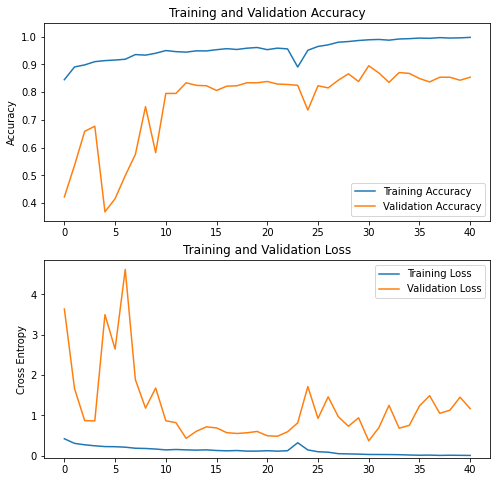

In [18]:
"""Visualizing the training and Validation performance"""
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-0.05,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

**Save the trainedmodel**

we save both weights in .h5 file and also save the entire model

In [19]:
fineTune_epoch = len(acc2);
# if early stopping happened, automatically best weights are restored, however
# if training completed, then load best weights from model checkpoint path
if fineTune_epoch >=(final_epoch-resume_epoch):
  # The model weights (that are considered the best) are loaded into the model.
  model.load_weights(checkpoint_filepath)
  print('Weights from model checkpoint loaded')

# Save the model
saveFolderPath = saveModelPath+'SavedModels/'+modelName
model.save(saveFolderPath)
model.save(saveFolderPath+'.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/A_ClassifierModels/SavedModels/SquuezeNet_optimizer_RMSprop/assets


**Apply some test images**

Load model

In [20]:
#saved_model_path = saveModelPath+modelName
new_model = tf.keras.models.load_model(saveFolderPath)

# Check its architecture
new_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 squeezenet (Functional)        (None, 13, 13, 512)  722496      ['input_4[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 13, 13, 64)   32832       ['squeezenet[0][0]']             
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 13, 13, 64)  256         ['conv2d_3[0][0]']         

In [21]:
"""Prepare Data For TESTING"""
batchsize = 20
img_height = 224
img_width = 224
# (img_height,img_width)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/THREE_CLASSES+1/TEST',
        target_size=(img_height,img_width),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
# put shuffle=False when you do test_datagen.flow_from_directory() so the 
# samples don't get shuffled and have the same order as test_generator.classes 

Found 200 images belonging to 4 classes.


In [22]:

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
# Perform predictions
Y_pred = new_model.predict(test_generator)

# Pick prediction as the class with highest probability
y_pred = np.argmax(Y_pred, axis=1)

# Display the classifications report
print('Classification Report')
target_names = class_names
cr = classification_report(test_generator.classes, y_pred, target_names=target_names)
print(cr)

Classification Report
              precision    recall  f1-score   support

      impala       0.91      0.84      0.87        50
       other       0.81      0.94      0.87        50
     warthog       0.96      0.88      0.92        50
       zebra       1.00      1.00      1.00        50

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.92       200
weighted avg       0.92      0.92      0.92       200



Confusion matrix, without normalization


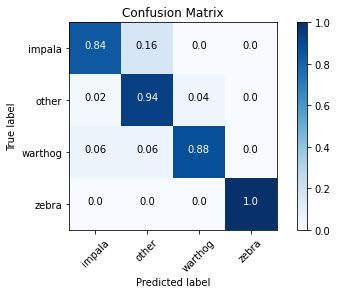

In [24]:
#get confusion_matrix, set normalize{‘true’
cm = confusion_matrix(test_generator.classes, y_pred,normalize='true')
cm = np.around(cm, decimals=2)

#Next, we define the labels for the confusion matrix. 
cm_plot_labels = ['impala', 'other', 'warthog', 'zebra']

# Lastly, we plot the confusion matrix by using the plot_confusion_matrix() 
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**display some sample test images and the prediction values**

200


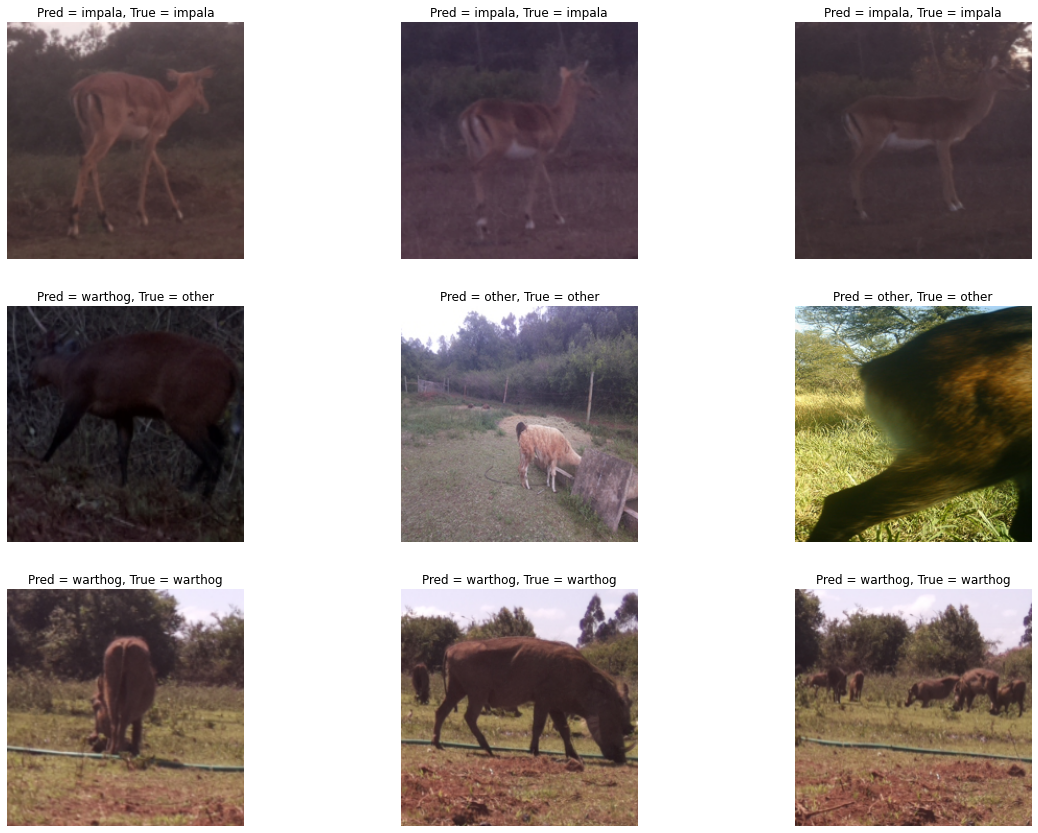

In [25]:
# Get the list of all files in directory tree at given path
listOfFiles = test_generator._filepaths
y_pred_class_codes=y_pred
print(len(listOfFiles))
i_max = 9 # it should match the number of images in the subplot figure
i = 0
k = 0
plt.figure(figsize=(20, 20))
while i < i_max:
  image_path = listOfFiles[k]
  pred_label = class_names[int(y_pred_class_codes[k])]
  true_label = class_names[int(test_generator.classes[k])]
  #print('The prediced species is: %s' %pred_label)
  #img = cv2.imread(image_path)
  img= skimage.io.imread(image_path,plugin='imageio')
  
  # Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in 
  # RGB mode. So color images will not be displayed correctly in Matplotlib if 
  # image is read with OpenCV. 

  # Convert BGR to RGB with OpenCV function cvtColor()
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(4, 3, i + 1)
  plt.imshow(img)
  plt.title('Pred = ' + pred_label +', True = '+true_label)
  plt.axis("off")

  i = i+1
  k = k+17   # add number not greater than len(listOfFiles)/i_max

**Find mis-predicted files**

200
b is greater than a
b is greater than a
b is greater than a
b is greater than a
b is greater than a
b is greater than a
b is greater than a
b is greater than a
b is greater than a


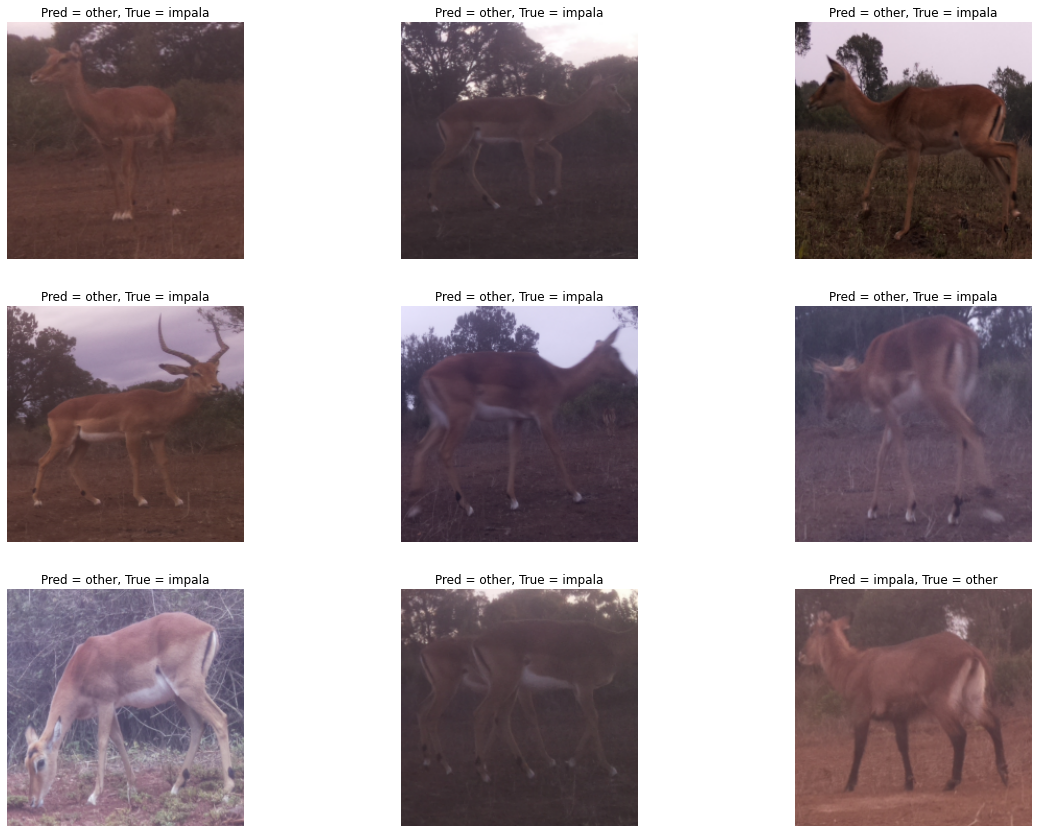

In [26]:
# Get the list of all files in directory tree at given path
listOfFiles = test_generator._filepaths
y_pred_class_codes=y_pred
print(len(listOfFiles))
i_max = len(listOfFiles) 
i = 0
k = 0
plt.figure(figsize=(20, 20))
while i < i_max:
  image_path = listOfFiles[i]
  pred_label = class_names[int(y_pred_class_codes[i])]
  true_label = class_names[int(test_generator.classes[i])]

  # identify miscalculated images
  if pred_label != true_label:
    print("b is greater than a")
    #print('The prediced species is: %s' %pred_label)
    #img = cv2.imread(image_path)
    img= skimage.io.imread(image_path,plugin='imageio')
    
    # Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in 
    # RGB mode. So color images will not be displayed correctly in Matplotlib if 
    # image is read with OpenCV. 

    # Convert BGR to RGB with OpenCV function cvtColor()
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 3, k + 1)
    plt.imshow(img)
    plt.title('Pred = ' + pred_label +', True = '+true_label)
    plt.axis("off")    
    k = k+1   # add number not greater than len(listOfFiles)/i_max
  if k>8:
    break
  i = i+1